In [75]:
# Author: Craig Waitt
# Date Created: 2/24/20
# Last Edited: 3/02/20

In [2]:
# General ASE and Python Modules Modules
import numpy as np
from ase.io import read, write
from ase.visualize import view
from ase import Atoms
from ase.build import molecule
from vasp import Vasp    # John Kitchins Vasp (will change from this when SGE and ASE are integratted)
import os
import glob
import matplotlib.pyplot as plt

# Import Modules for Genetic Algorithm (GA)
from ase.ga.data import PrepareDB
from ase.ga.bulk_startgenerator import StartGenerator
from ase.ga.utilities import closest_distances_generator, get_all_atom_types
from ase.neighborlist import NeighborList, natural_cutoffs
from ase.db.core import Database, connect
from ase.db import connect
from ase.ga.data import DataConnection
from ase.ga.population import Population
from ase.ga.standard_comparators import *
from ase.ga.bulk_crossovers import CutAndSplicePairing
from ase.ga.utilities import closest_distances_generator
from ase.ga.utilities import get_all_atom_types
from ase.ga.offspring_creator import OperationSelector

In [1]:
# If you shut down the kernal and restart go to section Prepare DB


# Import Structural Information

In [24]:
# Two structural inputs are needed to Generate a random structure DB. 
# Make all changes to your structural inputs here before preceding
    # STRUCT contains the framework/surface that is uniform (not changing)
    # Adsorb is the molecule that is moving about the framework or surface
    # At present, the code has been set to generate a DB with only 1 Adsorbate

n = 1                                              # number of adsorbate molecules you are going to add    
    
STRUCT = read('AEI-Si-48T.cif')
ADSORB = read('DMDMP-T.cif')                       # optimize adsorbate in Avogadro
ADSORB_TOT = len(ADSORB)*n                         # total number of adsorbate molecules
STRUCTcount = len(STRUCT)
ADSORBcount = len(ADSORB)

# Define Sampling Unit Cell

In [27]:
# In order to conserve bond connectivity, the code generates a random sampling of adsorbates then puts them
#    into the zeolite framework. Define a volume that you ideally want the adsorbate to sample. Your box can
#    as big or as small as you like. This will take some testing so pick some numbers, then adjust them if
#    needed before submitting calculations

STRUCT.translate([0,-6,4])                                          # move STRUCT to try to accomidate periodic images when eliminating bad candidates

ADSORB_CELL = [[3,0,0],[0,12,0],[0,0,3]]                            # Cell that adsorbate will sample
ADSORB_VOL = ADSORB_CELL[0][0]*ADSORB_CELL[1][1]*ADSORB_CELL[2][2]  # Volume of Cell
ADSORB.set_cell(ADSORB_CELL)
ADSORB.center()
ADSORB.set_tags(1)                                                  # You must Tag unique adsorbates for GA to work
                                                                    # They can be any number, this maintains the moitey 
    

# Begin Constructing the Initial DB

In [76]:
# Initialize Random Data Set

ATOM_NUM = ADSORB.get_atomic_numbers()                       # Get Atomic numbers of your adsorbate
unique_atom_types = get_all_atom_types(STRUCT, ATOM_NUM)     # Get the atomic numbers of your entire system
cd = closest_distances_generator(atom_numbers=unique_atom_types, 
                                ratio_of_covalent_radii=0.7) # Generate a dictionary of closest distance

population_size = 200                     # How many candidates do you want to make. For test purposes use a small number
sg = StartGenerator([(ADSORB,n)],         # How many clusters of your adsorbate do you want to look at
                    cd,                   # Minimum distance adorbates can be in within cluster
                    ADSORB_VOL,           # Volume of Cell
                    cell=ADSORB_CELL)     # Fix Cell dimensions for ease later

starting_population = [sg.get_new_candidate() for i in range(population_size)] # Generate Adsorbate in Cell
#view(starting_population)

Start_Set = []                                                        # Will contain the final candidates
for i in range(population_size):
    TEMPMOL = STRUCT +  starting_population[i]                        # Add the adsorbates to the frame work
    Start_Set.append(TEMPMOL)

### Your Adsorbate is located randomly in your unit cell
### Move the atoms to the prefered location

Cent_Pos = [6,7.6,8.5]                                                # Place where you want your adsorbate centered
Ads_num = len(ADSORB)*n                                               # Total number of adsorbate atoms
Fin_atoms = np.linspace(0,Ads_num-1,Ads_num)        
# Counting for the for loop

for i in range(population_size):
    for j in Fin_atoms:
        Coord = Start_Set[i].get_positions()[-(int(j)+1)] + Cent_Pos  # Move the corner of the adsorbate cell to p.o.i.
        Start_Set[i][-(int(j)+1)].x = Coord[0] - ADSORB_CELL[0][0]/2                       # Then you have to fudge the box so its centered
        Start_Set[i][-(int(j)+1)].y = Coord[1] - ADSORB_CELL[1][1]/2                      #      around the p.o.i.
        Start_Set[i][-(int(j)+1)].z = Coord[2] - ADSORB_CELL[2][2]/2

    Start_Set[i].wrap()
    
view(Start_Set)


# Remove Overlapping Atoms

In [7]:
# Now we will eliminate candidates that have overlapping atoms
# The more Starting Candidates there are the longer this will take

Tot_Atoms = len(Start_Set[0])                                           # Get the total number of atoms
Num_Ads = Tot_Atoms - ADSORB_TOT                                        # Get the index of the first adsorbate atom
ADS_ind = list(range(Num_Ads,Tot_Atoms))                                # Get indicies of each adsorbate

Nat_Cut = natural_cutoffs(Start_Set[0])                                 # Cutoff radii to get neighbors
Candidate_Error = []                                                    # Storage for candidate overlaps
for i in range(population_size):
    Neigh = NeighborList(Nat_Cut,bothways=True)
    Neigh.update(Start_Set[i])                                          # Generate Neighbor list
    
    for a in ADS_ind:
        indices,offsets = Neigh.get_neighbors(a)                        # Get Indicies of neighbors of adsorbate atom a  
        indices = indices[:-1]                                          # remove adsorbate a from list leaving behind neighbors
        indices = indices[1:]                                          
        Distances = Start_Set[i].get_distances(a,indices)               # Get the distances of atom a and its neighbors

        Atom_Nat_Cut = []
        for m in indices:
            Mol_Syms = Start_Set[i].get_chemical_symbols()              # Get the natural cutoff for each neighbor
            Atom_Sym = Mol_Syms[m]
            tmp_Atom = Atoms(Atom_Sym,positions=[(0,0,0)])
            Atom_Nat_Cut.append(natural_cutoffs(tmp_Atom,mult=1.2))
            Atom_Nat_list = []
            for l in Atom_Nat_Cut:
                Atom_Nat_list += l
                
        Atom_Distance = Distances - Atom_Nat_list                       # Compute the overlap
        
        for num in Atom_Distance:                                       # Get Candidates with an overlap
            if num <= 0:
                #print('Candidate {0} has a possible overlap'.format(i))
                Candidate_Error.append(i)
                break
            else:
                continue

Candidate_Error = np.unique(Candidate_Error)

#print(Candidate_Error)
print('Out of {0} Candidates, {1} overlaps have been possibly detected!!! Continue to remove them from the list !!!'.format(len(Start_Set),len(Candidate_Error)))
print(' ')
print('If this is too many go back and adjust the sampling volume, position of box, or generate an new test set.')
print(' ')
print('Look at Candidate_Error to see the index of each Candidate that should be removed')

# Creat the Final parent set to put into a DB
Parent_Set = []
for i in range(0,len(Start_Set)):
    if i in Candidate_Error:
        continue
    Parent_Set.append(Start_Set[i])
    
view(Parent_Set)

Out of 200 Candidates, 160 overlaps have been possibly detected!!! Continue to remove them from the list !!!
 
If this is too many go back and adjust the sampling volume, position of box, or generate an new test set.
 
Look at Candidate_Error to see the index of each Candidate that should be removed


# Create the DB to start the GA

In [8]:
# create the database to store information in
db_file = 'gadb_init.db'
d = PrepareDB(db_file_name=db_file,
              simulation_cell=STRUCT,
              stoichiometry=ATOM_NUM)

for a in Parent_Set:
    d.add_unrelaxed_candidate(a)    # The first element in the DB is the Framework without the Adsorbate
                                    # this is needed for the GA


In [22]:
%%bash
ase db gadb_init.db 

id|age|user  |formula      |calculator|   energy| fmax|pbc|  volume|charge|    mass| smax|magmom
 1|84m|cwaitt|O96Si48      |          |         |     |TTT|3189.363| 0.000|2883.984|     |      
 2|84m|cwaitt|C10H20O96Si48|vasp      |-1304.757|0.030|TTT|3189.363| 0.000|3024.254|0.013| 0.000
 3|84m|cwaitt|C10H20O96Si48|vasp      |-1304.781|0.021|TTT|3189.363| 0.000|3024.254|0.013| 0.000
 4|84m|cwaitt|C10H20O96Si48|vasp      |-1304.669|0.029|TTT|3189.363| 0.000|3024.254|0.012| 0.000
 5|84m|cwaitt|C10H20O96Si48|vasp      |-1304.736|0.030|TTT|3189.363| 0.000|3024.254|0.011| 0.000
 6|84m|cwaitt|C10H20O96Si48|vasp      |-1304.758|0.029|TTT|3189.363| 0.000|3024.254|0.012| 0.000
 7|84m|cwaitt|C10H20O96Si48|vasp      |-1304.788|0.025|TTT|3189.363| 0.000|3024.254|0.012| 0.000
 8|84m|cwaitt|C10H20O96Si48|vasp      |-1304.767|0.029|TTT|3189.363| 0.000|3024.254|0.013| 0.000
 9|84m|cwaitt|C10H20O96Si48|vasp      |-1304.637|0.027|TTT|3189.363| 0.000|3024.254|0.012| 0.000
10|84m|cwaitt|C10H20O96Si48|va

# Prepare DB for GA

In [4]:
# Set the Population Generator variables

population_size = 28  # Number of canidates in the DB (number of rows minus 1)
n_to_test = 10                                         # Number of Children to genertate

# Define the calculator that will be used for all subsequent calculations'
# Geometry optimizations preformed as specified below

def Calc(db_ind,candidate):                               
    return Vasp('Candidates/Candidate-{:02d}/'.format(int(db_ind)),
                xc = 'pbe', 
                encut = 400,                                
                ediff = 1e-5,
                ediffg = -0.03, 
                ibrion = 2,
                isif = 2, 
                nsw = 600,
                ispin = 2,
#                magmom = np.repeat(1,len(candidate)).tolist(),
                nelm = 60,
                sigma = 0.01,
                ismear = 0,
                lreal='A',
                ncore = 24,                                   # set ncore depending on number of cores
                atoms = candidate)

db = connect('gadb_init.db')                     # connects to the DB
db_index = range(1,population_size+1)            # get the indicies (in python notation (i.e. id=1 has an index=0)


print(db_index)

range(1, 29)


In [ ]:
# Write input using a cheap optimization method
 for i in db_index:                           # write an input file for each job
        parent = read('gadb_init.db@{0}'.format(i))
        calc = Calc(i+1,parent)
        calc.write_input()
    
# Submit Jobs, wait for them to complete before proceeding

# Check Energy Profile (optional)

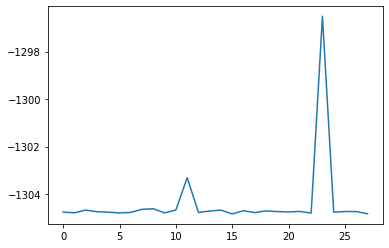

In [6]:
# Now go through the new DB and find the lowest energy configuration
Energy_G0 = []
for i in db_index:
    a = Vasp('Candidates/Candidate-{:02d}/'.format(i+1))
    Energy_G0.append(a.get_potential_energy())
# This will also check if any calculations need to be resubmited    
plt.plot(Energy_G0)
plt.show()

In [5]:
Min_Ind = np.argsort(Energy_G0)
Min_E = []
Min_Can = []
for i in Min_Ind:
    Min_E.append('{0:.3f}'.format(Energy_G0[i]-min(Energy_G0)))
    Min_Can.append('{:02d}'.format(i+2))

    
for i in range(0,len(Min_E)):
    print('{0} -> {1}'.format(Min_E[i],Min_Can[i]))


0.000 -> 17
0.007 -> 29
0.035 -> 24
0.043 -> 07
0.044 -> 11
0.049 -> 03
0.056 -> 19
0.063 -> 14
0.064 -> 08
0.072 -> 26
0.072 -> 06
0.074 -> 02
0.083 -> 22
0.094 -> 05
0.099 -> 21
0.100 -> 28
0.101 -> 27
0.104 -> 23
0.121 -> 15
0.127 -> 20
0.134 -> 18
0.160 -> 16
0.161 -> 04
0.163 -> 12
0.194 -> 09
0.217 -> 10
1.525 -> 13
8.317 -> 25


# Update Parents

In [6]:
for i in db_index:
    calc = Vasp('Candidates/Candidate-{:02d}'.format(int(i+1)))
    print('Candidate-{:02d}/'.format(int(i+1)))
    a = calc.get_atoms()
    a.set_tags(np.concatenate((np.zeros(STRUCTcount),np.ones(ADSORBcount)))) # set atom tags
    db.update(i+1,a)        # grab the minimized energies and update the database

Candidate-02/
Candidate-03/
Candidate-04/
Candidate-05/
Candidate-06/
Candidate-07/
Candidate-08/
Candidate-09/
Candidate-10/
Candidate-11/
Candidate-12/
Candidate-13/
Candidate-14/
Candidate-15/
Candidate-16/
Candidate-17/
Candidate-18/
Candidate-19/
Candidate-20/
Candidate-21/
Candidate-22/
Candidate-23/
Candidate-24/
Candidate-25/
Candidate-26/
Candidate-27/
Candidate-28/
Candidate-29/


In [12]:
da = DataConnection('gadb_init.db')    # The first row of the database contains the surface/framework w/out the adsorbate.
for i in db_index:
    a = da.get_an_unrelaxed_candidate()
    print('Updating Candidate {0}'.format(a.info['confid']))
    da.c.update(a.info['confid'],atoms=None,            # update the DB with pertinent information
                origin='StartingCandidateRelaxed',
                raw_score= -a.get_potential_energy(),
                relaxed=True)


Updating Candidate 2
Updating Candidate 3
Updating Candidate 4
Updating Candidate 5
Updating Candidate 6
Updating Candidate 7
Updating Candidate 8
Updating Candidate 9
Updating Candidate 10
Updating Candidate 11
Updating Candidate 12
Updating Candidate 13
Updating Candidate 14
Updating Candidate 15
Updating Candidate 16
Updating Candidate 17
Updating Candidate 18
Updating Candidate 19
Updating Candidate 20
Updating Candidate 21
Updating Candidate 22
Updating Candidate 23
Updating Candidate 24
Updating Candidate 25
Updating Candidate 26
Updating Candidate 27
Updating Candidate 28
Updating Candidate 29


# Initialize different compenents of GA

In [13]:
atom_numbers_to_optimize = da.get_atom_numbers_to_optimize()  # adsorbate atom numbers to optimize
n_to_optimize = len(atom_numbers_to_optimize)*n               # number of atoms to optimize
slab = da.get_slab()
all_atom_types = get_all_atom_types(slab, atom_numbers_to_optimize)
blmin = closest_distances_generator(all_atom_types,
                                    ratio_of_covalent_radii=.7)   # closest distance atoms can be

comp = InteratomicDistanceComparator(n_top=None,
                                     pair_cor_cum_diff=0.015,
                                     pair_cor_max=0.7,
                                     dE=0.001,
                                     mic=True)                   # comparator to determine if parents should make childer

pairing = CutAndSplicePairing(blmin,None,use_tags=True,p1=.2)     # how children are generated (make sure your adsorbates are uniquely tagged)


# Create the population

In [14]:
population = Population(data_connection=da,              
                        population_size=population_size,
                        comparator=comp)


In [15]:
for i in range(n_to_test):
    print('Now starting configuration number {0}'.format(i))
    a1, a2 = population.get_two_candidates()

    a3, desc = pairing.get_new_individual([a1, a2])
    print(a3.info)
    #view(a3)
    if a3 is None:
        continue
    da.add_unrelaxed_candidate(a3, description=desc)



Now starting configuration number 0
{'key_value_pairs': {'extinct': 0, 'origin': 'CutAndSplicePairing'}, 'data': {'parents': [3, 16]}}
Now starting configuration number 1
{'key_value_pairs': {'extinct': 0, 'origin': 'CutAndSplicePairing'}, 'data': {'parents': [2, 29]}}
Now starting configuration number 2
{'key_value_pairs': {'extinct': 0, 'origin': 'CutAndSplicePairing'}, 'data': {'parents': [14, 29]}}
Now starting configuration number 3
{'key_value_pairs': {'extinct': 0, 'origin': 'CutAndSplicePairing'}, 'data': {'parents': [19, 8]}}
Now starting configuration number 4
{'key_value_pairs': {'extinct': 0, 'origin': 'CutAndSplicePairing'}, 'data': {'parents': [24, 17]}}
Now starting configuration number 5
{'key_value_pairs': {'extinct': 0, 'origin': 'CutAndSplicePairing'}, 'data': {'parents': [13, 18]}}
Now starting configuration number 6
{'key_value_pairs': {'extinct': 0, 'origin': 'CutAndSplicePairing'}, 'data': {'parents': [3, 5]}}
Now starting configuration number 7
{'key_value_pairs

# Optimize the Children

In [16]:
# Get the children and optimize those
child_index = range((population_size+1),(population_size+1+n_to_test))
for i in child_index:                           # write and input file for each job
    child = read('gadb_init.db@{0}'.format(i))
    calc = Calc(i+1,child)
    calc.write_input()

# Get Children and Parents into a new DB (and see if addtitional generations are needed)

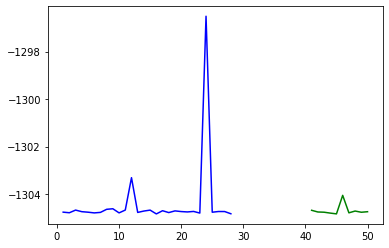

In [11]:
#gen1_index = range((population_size+1),(population_size+1+n_to_test))
gen1_index = range(41,(41+n_to_test))
Energy_G1 = []

for i in gen1_index:
    calc = Vasp('Candidates/Candidate-{:02d}/'.format(i-11))
    a = calc.get_atoms()
    a.set_tags(np.concatenate((np.zeros(STRUCTcount),np.ones(ADSORBcount)))) # set atom tags
    db.update(i+1,a)   
    Energy_G1.append(a.get_potential_energy())
    

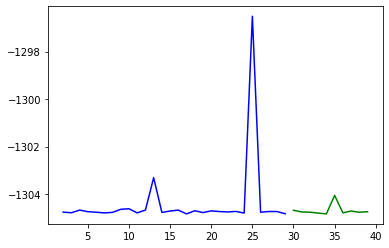

In [23]:
## This will also check if any calculations need to be resubmited    
plt.plot(range(2,(population_size+2)),Energy,'b')
plt.plot(range(41-11,(41-11+n_to_test)),Energy_G1,'g')
plt.show()


In [65]:
db_file_2 = 'ga_gen1.db'
db = connect(db_file_2)

d = PrepareDB(db_file_name=db_file_2,
              simulation_cell=STRUCT,
              stoichiometry=ATOM_NUM)

Can_fold = glob.glob('Candidates/Candidate-*')

F_Can = sorted(Can_fold)
j=1

for m in F_Can:
#     print(m)
    calc = Vasp(m)
    a = calc.get_atoms()
    a.set_tags(np.concatenate((np.zeros(STRUCTcount),np.ones(ADSORBcount)))) # set atom tags

    a.info['confid'] = j
    j+1    
    d.add_unrelaxed_candidate(a)
    d.c.update(a.info['confid'],atoms=None,            # update the DB with pertinent information
                origin='StartingCandidateRelaxed',
                raw_score= -a.get_potential_energy(),
                relaxed=True)


Candidate 17 has the lowest energy and is a likely candidate for the global minimum
This structure was determined to be a parent candidate
0.000 -> 17
0.002 -> 34
0.007 -> 29
0.034 -> 33
0.035 -> 24
0.043 -> 07
0.044 -> 11
0.046 -> 36
0.049 -> 03
0.056 -> 19


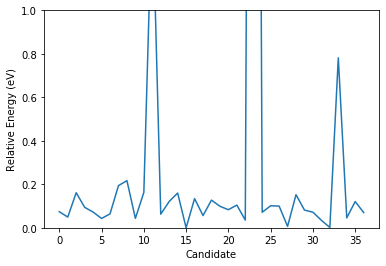

In [66]:
# Now go through the new DB and find the lowest energy configuration
Energy = []
da = DataConnection(db_file_2)
db = connect(db_file_2)

for i in range(1,db.count()-1):
    a = read('{0}@{1}'.format(db_file_2,i))
    Energy.append(a.get_potential_energy())
## find the loweest energy structure
MinE_I = np.argmin(Energy)
print('Candidate {0} has the lowest energy and is a likely candidate for the global minimum'.format(MinE_I+2))
if MinE_I < population_size:
    print('This structure was determined to be a parent candidate')
else:
    print('This structure was determined to be a child')


# show the 20 lowest energy structure
Min_Ind = np.argsort(Energy)[0:10]
Min_E = []
Min_Can = []
for i in Min_Ind:
    Min_E.append('{0:.3f}'.format(Energy[i]-min(Energy)))
    Min_Can.append('{:02d}'.format(i+2))

    
for i in range(0,len(Min_E)):
    print('{0} -> {1}'.format(Min_E[i],Min_Can[i]))

plt.plot(Energy-np.min(Energy))
plt.ylim((0, 1))
plt.xlabel('Candidate')
plt.ylabel('Relative Energy (eV)')
plt.show()

# Generate 2nd Generation of Children

In [67]:
atom_numbers_to_optimize = da.get_atom_numbers_to_optimize()  # adsorbate atom numbers to optimize
n_to_optimize = len(atom_numbers_to_optimize)*n               # number of atoms to optimize
slab = da.get_slab()
all_atom_types = get_all_atom_types(slab, atom_numbers_to_optimize)
blmin = closest_distances_generator(all_atom_types,
                                    ratio_of_covalent_radii=.7)   # closest distance atoms can be

comp = InteratomicDistanceComparator(n_top=None,
                                     pair_cor_cum_diff=0.015,
                                     pair_cor_max=0.7,
                                     dE=0.001,
                                     mic=True)                   # comparator to determine if parents should make childer

pairing = CutAndSplicePairing(blmin,None,use_tags=True,p1=.2)     # how children are generated (make sure your adsorbates are uniquely tagged)


In [68]:
population_size = db.count()-1
population = Population(data_connection=da,              
                        population_size=population_size,
                        comparator=comp)

In [71]:
for i in range(1):
    print('Now starting configuration number {0}'.format(i))
    a1, a2 = population.get_two_candidates()

    a3, desc = pairing.get_new_individual([a1, a2])
    print(a3)
    if a3 is None:
        continue
    da.add_unrelaxed_candidate(a3, description=desc)

Now starting configuration number 0
Atoms(symbols='C10H20O96Si48', pbc=True, cell=[13.677, 12.607, 18.497], tags=...)


In [72]:
# Get the children and optimize those
child_index = range((population_size+1),(population_size+1+n_to_test))
for i in child_index:                           # write and input file for each job
    child = read('ga_gen1.db@{0}'.format(i))
    calc = Calc(i+1,child)
    calc.write_input()

{'key_value_pairs': {'extinct': 0, 'origin': 'CutAndSplicePairing'}, 'data': {'parents': [19, 26]}, 'confid': 49}
